In [2]:
! pip install datasets


In [3]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import random
import zipfile
from google.colab import drive

In [4]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# define a PyTorch Dataset class for handling SMILES strings and targets

# TODO: your code goes here
class SMILESDataset(Dataset):

  def __init__(self, data, tokenizer, max_length):
      self.data = data
      self.tokenizer = tokenizer
      self.max_len = max_length

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      row = self.data[idx]
      SMILES = row['SMILES']
      label = row['label']

      inputs = self.tokenizer.encode_plus(
      SMILES,
      add_special_tokens=True,
      max_length=self.max_len,
      padding='max_length',
      return_token_type_ids=False,
      truncation=True
  )

      return {
    'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
    'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
    'target': torch.tensor(label, dtype=torch.float)  # Directly convert the target to float
}



In [6]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# applying the influential points selection algorithm

In [9]:
import os
from datasets import Dataset as HF_Dataset
from datasets import concatenate_datasets



drive.mount('/content/drive', force_remount=True)

# load the influence score
path = '/content/drive/MyDrive/Colab Notebooks'
os.chdir(path)
influence_scores = pd.read_csv("ranked_indices_full_set.csv")


positive_count = influence_scores[influence_scores['Influence Score'] > 0].shape[0]
print(positive_count)
print(influence_scores.iloc[100])

Mounted at /content/drive
161
Index               8.00000
Influence Score    37.25246
Name: 100, dtype: float64


In [10]:
# setting new train data with top 100 influential ext_data points
ext_data = pd.read_csv("External-Dataset_for_Task2.csv")
ext_data = ext_data.iloc[influence_scores.iloc[:100]['Index']] # selecting top 100 points
ext_data = ext_data.rename(columns={"Label": "label"}) # making column names consistent
ext_dataset = HF_Dataset.from_pandas(ext_data)
ext_dataset = ext_dataset.remove_columns(["__index__"]) if "__index__" in ext_dataset.column_names else ext_dataset

# train-test-val split
split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42) # 80:20
train_valid_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]
split_train_valid = train_valid_dataset.train_test_split(test_size=0.1, seed=42) # 90:10
train_dataset = split_train_valid["train"]
valid_dataset = split_train_valid["test"]
combined_train = concatenate_datasets([train_dataset, ext_dataset])

# create dataset and dataloader
combined_train = SMILESDataset(combined_train, tokenizer, max_length=128)
valid_dataset = SMILESDataset(valid_dataset, tokenizer, max_length=128)
test_dataset  = SMILESDataset(test_dataset, tokenizer, max_length=128)
reg_train_loader = DataLoader(combined_train, batch_size=16, shuffle=True)
reg_valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
reg_test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [11]:
# We need to add a regression head on the language model as we are doing a regression task.

# specify model with a regression head

class MoLFormerWithRegressionHead(nn.Module):
    # TODO: your code goes here
  def __init__(self,model):
    super().__init__()
    self.pretrained = model
    hidden_size = self.pretrained.config.hidden_size


    self.regression = nn.Linear(hidden_size, 1)


  def forward(self, ids, mask):
    # pass input to the pre-trained model
    output = self.pretrained(ids, attention_mask=mask)
    # extracts the last hidden state
    hidden_states = output.last_hidden_state
    # selects the cls token, represents the summary of the entire sequence
    cls_representation = hidden_states[:, 0, :]

    output = self.regression(cls_representation)
    return output.squeeze(-1) # to remove the last dimension



# helpful Functions for training and early stopping

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False


In [13]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np

def train_model(model,reg_train_loader,reg_valid_loader,EPOCHS=20,LEARNING_RATE=1e-7,patience=5, min_delta=0.001):
    """
    Train the given model using LoRA (or standard) fine-tuning with early stopping and linear LR scheduler.

    Args:
        model (nn.Module): The model to train.
        reg_train_loader (DataLoader): Training data loader.
        reg_valid_loader (DataLoader): Validation data loader.
        EPOCHS (int): Number of epochs to train.
        LEARNING_RATE (float): Initial learning rate.
        patience (int): Patience for early stopping.
        min_delta (float): Minimum delta for early stopping improvement check.

    Returns:
        tuple: (train_loss_history, valid_loss_history)
    """

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define optimizer, scheduler, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=EPOCHS)
    loss_fn = torch.nn.MSELoss()

    # EarlyStopping is assumed to be a class you’ve defined or imported
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

    # Lists to store losses for plotting
    train_loss_history = []
    valid_loss_history = []

    for epoch in range(EPOCHS):
        model.train()
        total_train_loss = 0.0

        # Training loop
        for batch in tqdm(reg_train_loader, desc=f"Epoch {epoch+1} Training"):
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            outputs = model(ids, mask)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * ids.size(0)

        scheduler.step()  # Update the learning rate at the end of each epoch

        avg_train_loss = total_train_loss / len(reg_train_loader.dataset)
        train_loss_history.append(avg_train_loss)
        print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

        # Validation loop
        model.eval()
        total_valid_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(reg_valid_loader, desc=f"Epoch {epoch+1} Validation"):
                ids = batch['ids'].to(device)
                mask = batch['mask'].to(device)
                targets = batch['target'].to(device)

                outputs = model(ids, mask)
                loss = loss_fn(outputs, targets)
                total_valid_loss += loss.item() * ids.size(0)

        avg_valid_loss = total_valid_loss / len(reg_valid_loader.dataset)
        valid_loss_history.append(avg_valid_loss)
        print(f"Epoch {epoch+1} - Validation Loss: {np.sqrt(avg_valid_loss):.4f}")

        # Early stopping check
        if early_stopping.step(avg_valid_loss):
            print("Early stopping triggered")
            break

    # take sqrt to return RMSE instead of MSE
    return np.sqrt(train_loss_history), np.sqrt(valid_loss_history)


# Load the finetuned model from task 1

In [14]:

# Specify the path to the zipped model file in Google Drive
zip_file_path = '/content/drive/My Drive/Colab Notebooks/mlm_finetuned_model.zip'
extract_path = '/content/extracted_model'


# Extract the zipped model
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

model = AutoModel.from_pretrained(f'{extract_path}/mlm_finetuned_model', trust_remote_code=True)


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [15]:
# initialize the regression model with the added regression layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)

# Full finetuning

In [16]:
# here tuning all weights and biases of the model before applying any approaches

In [17]:
model = AutoModel.from_pretrained(f'{extract_path}/mlm_finetuned_model', trust_remote_code=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)

In [18]:
train_losses, val_losses = train_model(
    model=regression_model,
    reg_train_loader=reg_train_loader,
    reg_valid_loader=reg_valid_loader,
    EPOCHS=20,
    LEARNING_RATE=1e-7,
    patience=5,
    min_delta=0.001
)

Epoch 1 Training: 100%|██████████| 196/196 [00:38<00:00,  5.14it/s]


Epoch 1 - Training Loss: 4.0477


Epoch 1 Validation: 100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


Epoch 1 - Validation Loss: 1.9397


Epoch 2 Training: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]


Epoch 2 - Training Loss: 3.3987


Epoch 2 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.81it/s]


Epoch 2 - Validation Loss: 1.7745


Epoch 3 Training: 100%|██████████| 196/196 [00:39<00:00,  4.90it/s]


Epoch 3 - Training Loss: 2.8895


Epoch 3 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.03it/s]


Epoch 3 - Validation Loss: 1.6466


Epoch 4 Training: 100%|██████████| 196/196 [00:39<00:00,  4.91it/s]


Epoch 4 - Training Loss: 2.5228


Epoch 4 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.60it/s]


Epoch 4 - Validation Loss: 1.5319


Epoch 5 Training: 100%|██████████| 196/196 [00:39<00:00,  4.91it/s]


Epoch 5 - Training Loss: 2.2224


Epoch 5 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.23it/s]


Epoch 5 - Validation Loss: 1.4322


Epoch 6 Training: 100%|██████████| 196/196 [00:40<00:00,  4.90it/s]


Epoch 6 - Training Loss: 2.0137


Epoch 6 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.07it/s]


Epoch 6 - Validation Loss: 1.3456


Epoch 7 Training: 100%|██████████| 196/196 [00:39<00:00,  4.90it/s]


Epoch 7 - Training Loss: 1.8506


Epoch 7 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.19it/s]


Epoch 7 - Validation Loss: 1.3135


Epoch 8 Training: 100%|██████████| 196/196 [00:40<00:00,  4.89it/s]


Epoch 8 - Training Loss: 1.7354


Epoch 8 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.32it/s]


Epoch 8 - Validation Loss: 1.2713


Epoch 9 Training: 100%|██████████| 196/196 [00:39<00:00,  4.90it/s]


Epoch 9 - Training Loss: 1.6641


Epoch 9 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.35it/s]


Epoch 9 - Validation Loss: 1.2429


Epoch 10 Training: 100%|██████████| 196/196 [00:39<00:00,  4.91it/s]


Epoch 10 - Training Loss: 1.5952


Epoch 10 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.29it/s]


Epoch 10 - Validation Loss: 1.2174


Epoch 11 Training: 100%|██████████| 196/196 [00:40<00:00,  4.90it/s]


Epoch 11 - Training Loss: 1.5601


Epoch 11 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.99it/s]


Epoch 11 - Validation Loss: 1.2066


Epoch 12 Training: 100%|██████████| 196/196 [00:40<00:00,  4.89it/s]


Epoch 12 - Training Loss: 1.5474


Epoch 12 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.27it/s]


Epoch 12 - Validation Loss: 1.2084


Epoch 13 Training: 100%|██████████| 196/196 [00:39<00:00,  4.90it/s]


Epoch 13 - Training Loss: 1.5238


Epoch 13 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.47it/s]


Epoch 13 - Validation Loss: 1.2104


Epoch 14 Training: 100%|██████████| 196/196 [00:40<00:00,  4.89it/s]


Epoch 14 - Training Loss: 1.5159


Epoch 14 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.40it/s]


Epoch 14 - Validation Loss: 1.2033


Epoch 15 Training: 100%|██████████| 196/196 [00:40<00:00,  4.90it/s]


Epoch 15 - Training Loss: 1.4975


Epoch 15 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.37it/s]


Epoch 15 - Validation Loss: 1.1978


Epoch 16 Training: 100%|██████████| 196/196 [00:40<00:00,  4.89it/s]


Epoch 16 - Training Loss: 1.4830


Epoch 16 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.97it/s]


Epoch 16 - Validation Loss: 1.2076


Epoch 17 Training: 100%|██████████| 196/196 [00:40<00:00,  4.89it/s]


Epoch 17 - Training Loss: 1.4895


Epoch 17 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.26it/s]


Epoch 17 - Validation Loss: 1.1910


Epoch 18 Training: 100%|██████████| 196/196 [00:39<00:00,  4.90it/s]


Epoch 18 - Training Loss: 1.4706


Epoch 18 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.37it/s]


Epoch 18 - Validation Loss: 1.2005


Epoch 19 Training: 100%|██████████| 196/196 [00:39<00:00,  4.90it/s]


Epoch 19 - Training Loss: 1.4831


Epoch 19 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.44it/s]


Epoch 19 - Validation Loss: 1.1871


Epoch 20 Training: 100%|██████████| 196/196 [00:39<00:00,  4.91it/s]


Epoch 20 - Training Loss: 1.4580


Epoch 20 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.43it/s]

Epoch 20 - Validation Loss: 1.1760


# plot training and validation losses using full finetuning

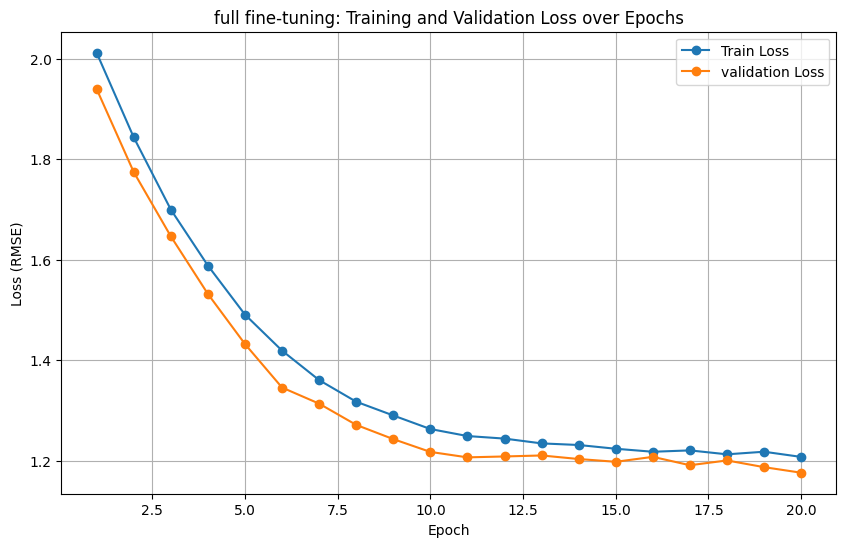

In [19]:
import matplotlib.pyplot as plt


epochs = list(range(1, len(train_losses)+1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
plt.title('full fine-tuning: Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("Full finetuning RMSE.png")
plt.show()

# Test the full fine-tuning approach on the test set

In [20]:
regression_model.eval()
loss_fn = torch.nn.MSELoss()

total_test_loss = 0.0
with torch.no_grad():
    for batch in tqdm(reg_test_loader, desc="Testing"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        outputs = regression_model(ids, mask)
        loss = loss_fn(outputs, targets)
        total_test_loss += loss.item() * ids.size(0)

avg_test_loss = total_test_loss / len(reg_test_loader.dataset)
print(f"Test Loss RMSE: {np.sqrt(avg_test_loss):.4f}")

Testing: 100%|██████████| 53/53 [00:03<00:00, 13.26it/s]

Test Loss RMSE: 1.1709


# 3_2_1: Finetuning  using bitfit

In [21]:
model = AutoModel.from_pretrained(f'{extract_path}/mlm_finetuned_model', trust_remote_code=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)

In [22]:
#Freeze all non-bias parameters
for name, param in regression_model.named_parameters():
    if 'bias' in name:
        param.requires_grad = True   # Allow training for bias terms
    else:
        param.requires_grad = False  # Freeze all other parameters


In [23]:
train_losses, val_losses = train_model(
    model=regression_model,
    reg_train_loader=reg_train_loader,
    reg_valid_loader=reg_valid_loader,
    EPOCHS=20,
    LEARNING_RATE=1e-7,
    patience=5,
    min_delta=0.001
)

Epoch 1 Training: 100%|██████████| 196/196 [00:28<00:00,  6.79it/s]


Epoch 1 - Training Loss: 9.4745


Epoch 1 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.37it/s]


Epoch 1 - Validation Loss: 3.1632


Epoch 2 Training: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]


Epoch 2 - Training Loss: 9.4750


Epoch 2 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.38it/s]


Epoch 2 - Validation Loss: 3.1538


Epoch 3 Training: 100%|██████████| 196/196 [00:28<00:00,  6.76it/s]


Epoch 3 - Training Loss: 9.4679


Epoch 3 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.26it/s]


Epoch 3 - Validation Loss: 3.1767


Epoch 4 Training: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]


Epoch 4 - Training Loss: 9.4305


Epoch 4 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.41it/s]


Epoch 4 - Validation Loss: 3.1480


Epoch 5 Training: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]


Epoch 5 - Training Loss: 9.4244


Epoch 5 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.28it/s]


Epoch 5 - Validation Loss: 3.1529


Epoch 6 Training: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]


Epoch 6 - Training Loss: 9.3492


Epoch 6 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.31it/s]


Epoch 6 - Validation Loss: 3.1404


Epoch 7 Training: 100%|██████████| 196/196 [00:28<00:00,  6.79it/s]


Epoch 7 - Training Loss: 9.3562


Epoch 7 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.29it/s]


Epoch 7 - Validation Loss: 3.1497


Epoch 8 Training: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]


Epoch 8 - Training Loss: 9.3882


Epoch 8 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.27it/s]


Epoch 8 - Validation Loss: 3.1349


Epoch 9 Training: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]


Epoch 9 - Training Loss: 9.3340


Epoch 9 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.19it/s]


Epoch 9 - Validation Loss: 3.1349


Epoch 10 Training: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]


Epoch 10 - Training Loss: 9.3090


Epoch 10 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.36it/s]


Epoch 10 - Validation Loss: 3.1242


Epoch 11 Training: 100%|██████████| 196/196 [00:28<00:00,  6.81it/s]


Epoch 11 - Training Loss: 9.3104


Epoch 11 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.13it/s]


Epoch 11 - Validation Loss: 3.1272


Epoch 12 Training: 100%|██████████| 196/196 [00:28<00:00,  6.79it/s]


Epoch 12 - Training Loss: 9.3028


Epoch 12 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.39it/s]


Epoch 12 - Validation Loss: 3.1367


Epoch 13 Training: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]


Epoch 13 - Training Loss: 9.2881


Epoch 13 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.40it/s]


Epoch 13 - Validation Loss: 3.1177


Epoch 14 Training: 100%|██████████| 196/196 [00:28<00:00,  6.79it/s]


Epoch 14 - Training Loss: 9.1932


Epoch 14 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.12it/s]


Epoch 14 - Validation Loss: 3.1288


Epoch 15 Training: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]


Epoch 15 - Training Loss: 9.1670


Epoch 15 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.51it/s]


Epoch 15 - Validation Loss: 3.1285


Epoch 16 Training: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]


Epoch 16 - Training Loss: 9.1797


Epoch 16 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.39it/s]


Epoch 16 - Validation Loss: 3.1237


Epoch 17 Training: 100%|██████████| 196/196 [00:28<00:00,  6.79it/s]


Epoch 17 - Training Loss: 9.2033


Epoch 17 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.97it/s]


Epoch 17 - Validation Loss: 3.1332


Epoch 18 Training: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]


Epoch 18 - Training Loss: 9.2028


Epoch 18 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.33it/s]


Epoch 18 - Validation Loss: 3.1107


Epoch 19 Training: 100%|██████████| 196/196 [00:28<00:00,  6.76it/s]


Epoch 19 - Training Loss: 9.1518


Epoch 19 Validation: 100%|██████████| 21/21 [00:01<00:00, 13.30it/s]


Epoch 19 - Validation Loss: 3.1186


Epoch 20 Training: 100%|██████████| 196/196 [00:29<00:00,  6.74it/s]


Epoch 20 - Training Loss: 9.2182


Epoch 20 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.89it/s]

Epoch 20 - Validation Loss: 3.1315


# Plot training and validation of BitFit

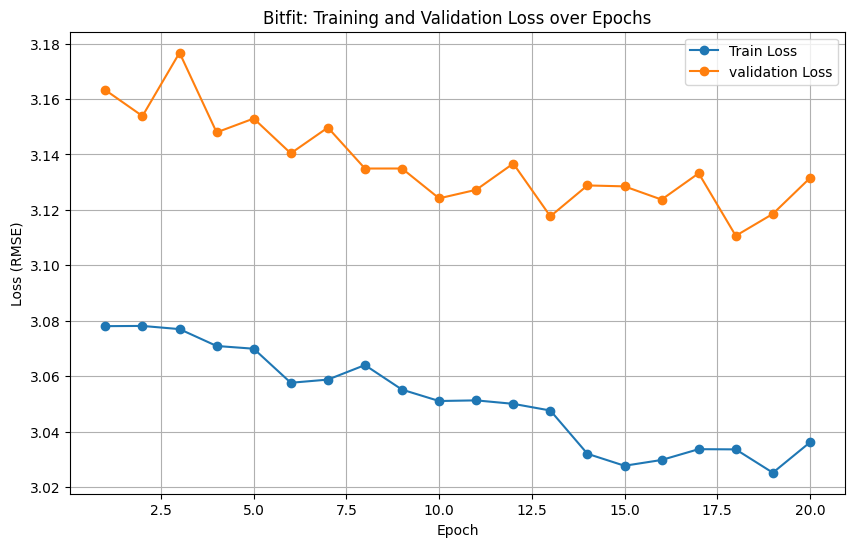

In [24]:
import matplotlib.pyplot as plt


epochs = list(range(1, len(train_losses)+1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
plt.title('Bitfit: Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("BitFit RMSE.png")
plt.show()

# test the BitFit approach on the test set

In [25]:
regression_model.eval()
loss_fn = torch.nn.MSELoss()

total_test_loss = 0.0
with torch.no_grad():
    for batch in tqdm(reg_test_loader, desc="Testing"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        outputs = regression_model(ids, mask)
        loss = loss_fn(outputs, targets)
        total_test_loss += loss.item() * ids.size(0)

avg_test_loss = total_test_loss / len(reg_test_loader.dataset)
print(f"Test Loss RMSE: {np.sqrt(avg_test_loss):.4f}")

Testing: 100%|██████████| 53/53 [00:03<00:00, 13.43it/s]


Test Loss RMSE: 3.0482


# 3_2_2 Implement Finetuning using LoRa

In [26]:
class LORALayer():
  def __init__(self, rank, alpha=1 ,dropout=0 ):
      self.rank= rank
      self.alpha= alpha
      self.dropout= nn.Dropout(p=dropout)

      self.scaling= self.alpha / self.rank



class Lora_Linear(nn.Linear, LORALayer): # inherits from both
  def __init__(self, in_features, out_features,rank =0,alpha=1,dropout=0, bias= True ):
    nn.Linear.__init__(self, in_features, out_features)
    LORALayer.__init__(self, rank, alpha, dropout)

    if rank>0:
      self.A =  nn.Parameter(self.weight.new_zeros((rank, in_features)))

      self.B =  nn.Parameter(self.weight.new_zeros((out_features,  rank)))

      # Freezing the pre-trained weight matrix
      self.weight.requires_grad = False

      # as per the paper, they initialized B with zeros and initialized A with Random gaussian.
      nn.init.normal_(self.A, mean=0.0, std=0.02)
      nn.init.zeros_(self.B)

  def forward(self, input):
    if self.rank >0:
      result = nn.functional.linear(input, self.weight, self.bias)
      result += (self.dropout(input) @ self.A.t() @ self.B.t() * self.scaling)
      return result

    else:
      return nn.functional.linear(input, self.weight, self.bias)









In [27]:
# function for iterating on the layers and apply lora on the attention layers
def replace_layer_with_lora( model,  rank, alpha , dropout,target_keywords=["query", "key", "value"]):

  for name,layer in model.named_children():

    # check if the next layer is instance of nn.Linear
    if isinstance(layer , nn.Linear):

      if target_keywords is None or any(kw in name for kw in target_keywords):


        # Create our LoRA-enabled linear layer with matching dimensions.
        lora_layer = Lora_Linear(
            in_features=layer.in_features,
            out_features=layer.out_features,
            rank=rank,
            alpha=alpha,
            dropout=dropout,
            bias=(layer.bias is not None)
        )

        # Copy over the original weights (and bias if available).
        lora_layer.weight.data = layer.weight.data.clone()
        if layer.bias is not None:
            lora_layer.bias = layer.bias
        # Replace the old layer with our new LoRA layer.
        setattr(model, name, lora_layer)
    else:
        # Recursively replace in child layer modules.
        replace_layer_with_lora(layer, rank, alpha, dropout ,target_keywords)



In [28]:
class MoLFormerWithRegression_Lora(nn.Module):
    def __init__(self, model, rank, alpha, lora_dropout=0.1):
        super().__init__()
        self.pretrained = model

        # apply LoRA to selected layers in the pretrained model.
        # the target layers with names that include "query", "key", or "value" (attention layers)

        target_keywords = ["query", "key", "value"]
        replace_layer_with_lora(self.pretrained,
                                 rank=rank, alpha=alpha, dropout=lora_dropout, target_keywords=target_keywords)

        hidden_size = self.pretrained.config.hidden_size

        # Replace the standard regression head with a LoRA-enabled linear layer.
        self.regression = Lora_Linear(
            in_features=hidden_size,
            out_features=1,
            rank=rank,
            alpha=alpha,
            dropout=lora_dropout,
        )

    def forward(self, ids, mask):
        # Pass the input through the pretrained model.
        outputs = self.pretrained(ids, attention_mask=mask)
        hidden_states = outputs.last_hidden_state
        # Use the first token ([CLS] token) as the summary representation.
        cls_representation = hidden_states[:, 0, :]
        # Get the regression output using our LoRA-enhanced head.
        output = self.regression(cls_representation)
        return output.squeeze(-1)  # Remove the last dimension for a scalar output



# Load the finetuned model from task1

In [29]:
import torch
import zipfile
from google.colab import drive


drive.mount('/content/drive', force_remount=True)
# Specify the path to your zipped model file in Google Drive
zip_file_path = '/content/drive/My Drive/Colab Notebooks/mlm_finetuned_model.zip'
extract_path = '/content/extracted_model'


# Extract the zipped model
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

model = AutoModel.from_pretrained(f'{extract_path}/mlm_finetuned_model', trust_remote_code=True)


Mounted at /content/drive


# Apply finetuning using Lora

In [30]:
# Load the base model and tokenizer from Hugging Face.
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
#model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)
# Create an instance of our model with LoRA applied to both the pretrained layers and the regression head.
model = MoLFormerWithRegression_Lora(model, rank=4, alpha=8, lora_dropout=0.1)


In [31]:
train_losses, val_losses = train_model(
    model=model,
    reg_train_loader=reg_train_loader,
    reg_valid_loader=reg_valid_loader,
    EPOCHS=20,
    LEARNING_RATE=1e-7,
    patience=5,
    min_delta=0.001
)



Epoch 1 Training: 100%|██████████| 196/196 [00:41<00:00,  4.77it/s]


Epoch 1 - Training Loss: 6.0551


Epoch 1 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.02it/s]


Epoch 1 - Validation Loss: 2.4454


Epoch 2 Training: 100%|██████████| 196/196 [00:40<00:00,  4.83it/s]


Epoch 2 - Training Loss: 5.4957


Epoch 2 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.22it/s]


Epoch 2 - Validation Loss: 2.3186


Epoch 3 Training: 100%|██████████| 196/196 [00:40<00:00,  4.80it/s]


Epoch 3 - Training Loss: 4.9534


Epoch 3 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.13it/s]


Epoch 3 - Validation Loss: 2.2051


Epoch 4 Training: 100%|██████████| 196/196 [00:40<00:00,  4.81it/s]


Epoch 4 - Training Loss: 4.5104


Epoch 4 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.79it/s]


Epoch 4 - Validation Loss: 2.1049


Epoch 5 Training: 100%|██████████| 196/196 [00:40<00:00,  4.81it/s]


Epoch 5 - Training Loss: 4.1662


Epoch 5 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.09it/s]


Epoch 5 - Validation Loss: 2.0190


Epoch 6 Training: 100%|██████████| 196/196 [00:40<00:00,  4.81it/s]


Epoch 6 - Training Loss: 3.8149


Epoch 6 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.10it/s]


Epoch 6 - Validation Loss: 1.9222


Epoch 7 Training: 100%|██████████| 196/196 [00:40<00:00,  4.81it/s]


Epoch 7 - Training Loss: 3.5236


Epoch 7 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.08it/s]


Epoch 7 - Validation Loss: 1.8435


Epoch 8 Training: 100%|██████████| 196/196 [00:40<00:00,  4.80it/s]


Epoch 8 - Training Loss: 3.2380


Epoch 8 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.70it/s]


Epoch 8 - Validation Loss: 1.7758


Epoch 9 Training: 100%|██████████| 196/196 [00:40<00:00,  4.80it/s]


Epoch 9 - Training Loss: 3.0471


Epoch 9 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.09it/s]


Epoch 9 - Validation Loss: 1.7088


Epoch 10 Training: 100%|██████████| 196/196 [00:40<00:00,  4.82it/s]


Epoch 10 - Training Loss: 2.8567


Epoch 10 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.18it/s]


Epoch 10 - Validation Loss: 1.6536


Epoch 11 Training: 100%|██████████| 196/196 [00:40<00:00,  4.82it/s]


Epoch 11 - Training Loss: 2.6926


Epoch 11 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.14it/s]


Epoch 11 - Validation Loss: 1.6084


Epoch 12 Training: 100%|██████████| 196/196 [00:40<00:00,  4.82it/s]


Epoch 12 - Training Loss: 2.5512


Epoch 12 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.82it/s]


Epoch 12 - Validation Loss: 1.5563


Epoch 13 Training: 100%|██████████| 196/196 [00:40<00:00,  4.83it/s]


Epoch 13 - Training Loss: 2.4450


Epoch 13 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.16it/s]


Epoch 13 - Validation Loss: 1.5210


Epoch 14 Training: 100%|██████████| 196/196 [00:40<00:00,  4.82it/s]


Epoch 14 - Training Loss: 2.3517


Epoch 14 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.11it/s]


Epoch 14 - Validation Loss: 1.4793


Epoch 15 Training: 100%|██████████| 196/196 [00:40<00:00,  4.82it/s]


Epoch 15 - Training Loss: 2.2697


Epoch 15 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.01it/s]


Epoch 15 - Validation Loss: 1.4717


Epoch 16 Training: 100%|██████████| 196/196 [00:40<00:00,  4.81it/s]


Epoch 16 - Training Loss: 2.1983


Epoch 16 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.92it/s]


Epoch 16 - Validation Loss: 1.4459


Epoch 17 Training: 100%|██████████| 196/196 [00:40<00:00,  4.81it/s]


Epoch 17 - Training Loss: 2.1383


Epoch 17 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.11it/s]


Epoch 17 - Validation Loss: 1.4141


Epoch 18 Training: 100%|██████████| 196/196 [00:40<00:00,  4.82it/s]


Epoch 18 - Training Loss: 2.1107


Epoch 18 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.16it/s]


Epoch 18 - Validation Loss: 1.4086


Epoch 19 Training: 100%|██████████| 196/196 [00:40<00:00,  4.82it/s]


Epoch 19 - Training Loss: 2.0774


Epoch 19 Validation: 100%|██████████| 21/21 [00:01<00:00, 11.80it/s]


Epoch 19 - Validation Loss: 1.4047


Epoch 20 Training: 100%|██████████| 196/196 [00:40<00:00,  4.82it/s]


Epoch 20 - Training Loss: 2.0691


Epoch 20 Validation: 100%|██████████| 21/21 [00:01<00:00, 12.16it/s]

Epoch 20 - Validation Loss: 1.3878


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-ea232d8f35f8>", line 13, in <cell line: 0>
    plt.savefig("Lora RMSE.png")
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py", line 1243, in savefig
    res = fig.savefig(*args, **kwargs)  # type: ignore[func-returns-value]
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/figure.py", line 3490, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/backend_bases.py", line 2184, in print_figure
    result = print_method(
             ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/backend_bases.py", line 2040, in <lambda>
    print_method = functools.wraps(meth)(lambda *args, **kwargs: meth(
                          

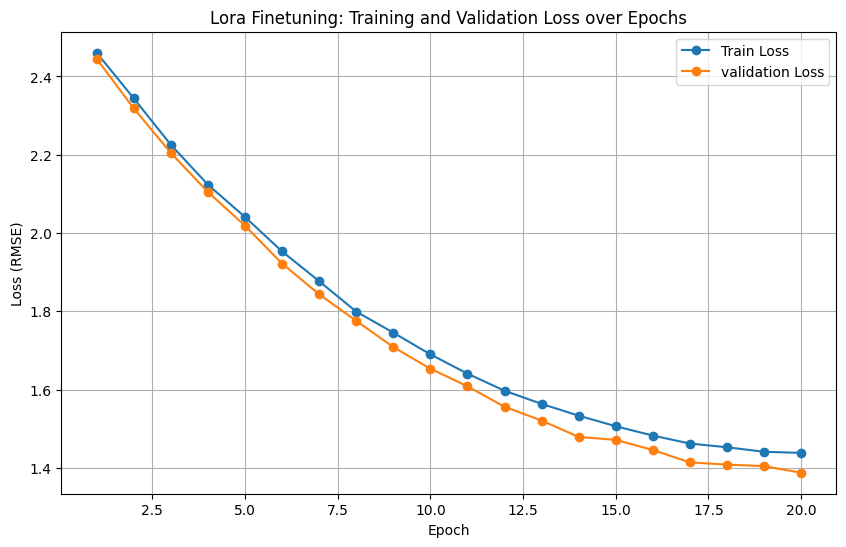

In [ ]:
import matplotlib.pyplot as plt


epochs = list(range(1, len(train_losses)+1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
plt.title('Lora Finetuning: Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("Lora RMSE.png")
plt.show()

In [32]:
#

# testing the approach on the test set

In [33]:
model.eval()
loss_fn = torch.nn.MSELoss()

total_test_loss = 0.0
with torch.no_grad():
    for batch in tqdm(reg_test_loader, desc="Testing"):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        outputs = model(ids, mask)
        loss = loss_fn(outputs, targets)
        total_test_loss += loss.item() * ids.size(0)

avg_test_loss = total_test_loss / len(reg_test_loader.dataset)
print(f"Test Loss RMSE: {np.sqrt(avg_test_loss):.4f}")

Testing: 100%|██████████| 53/53 [00:04<00:00, 12.22it/s]

Test Loss RMSE: 1.3889
